In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import joblib

In [5]:
# Load the dataset
file_path = r"C:\Users\User\Downloads\data.csv"
data = pd.read_csv(file_path)


In [6]:
# Display basic info and summary
print(data.info())
print(data.describe())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB
None
          footfall    tempMode          AQ         USS          CS  \
count   944.000000  944.000000  944.000000  944.000000  944.000000   
mean    306.381356    3.727754    4.325212    2.939619    5.394068   
std    1082.606745    2.677235    1.438436    1.383725    1.269349   
min       0.000000    0.000000    1.000000    1.000000    1.000000   
25%       1.000000  

In [7]:
# Check for missing values
print(data.isnull().sum())

footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64


In [8]:
# Distribution of numeric columns
fig = make_subplots(rows=5, cols=2, subplot_titles=data.columns)
for i, column in enumerate(data.columns):
    row = i // 2 + 1
    col = i % 2 + 1
    hist = px.histogram(data, x=column, template='plotly_dark', color_discrete_sequence=['#F63366'])
    hist.update_traces(marker_line_width=0.5, marker_line_color="white")
    fig.add_trace(hist.data[0], row=row, col=col)

fig.update_layout(height=1200, title_text="Distribution of Numeric Columns", title_font=dict(size=25), title_x=0.5, showlegend=False)
fig.show()


In [9]:
# Correlation Heatmap
corr = data.corr()
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=corr.round(2).values,
    showscale=True,
    colorscale='Viridis')
fig.update_layout(title_text='Correlation Heatmap', title_font=dict(size=25), title_x=0.5)
fig.show()

In [10]:
# Boxplots for each feature to identify outliers
fig = make_subplots(rows=5, cols=2, subplot_titles=data.columns[:-1])
for i, column in enumerate(data.columns[:-1]):  # Excluding the target column 'fail'
    row = i // 2 + 1
    col = i % 2 + 1
    box = px.box(data, y=column, template='plotly_dark', color_discrete_sequence=['#636EFA'])
    box.update_traces(marker_line_width=0.5, marker_line_color="white")
    fig.add_trace(box.data[0], row=row, col=col)

fig.update_layout(height=1200, title_text="Boxplots of Features", title_font=dict(size=25), title_x=0.5, showlegend=False)
fig.show()

In [11]:
# Scatter plots to visualize relationships between features and target
fig = make_subplots(rows=5, cols=2, subplot_titles=data.columns[:-1])
for i, column in enumerate(data.columns[:-1]):  # Excluding the target column 'fail'
    row = i // 2 + 1
    col = i % 2 + 1
    scatter = px.scatter(data, x=column, y='fail', template='plotly_dark', color='fail', color_continuous_scale='Viridis')
    scatter.update_traces(marker=dict(size=5, opacity=0.7, line=dict(width=0.5, color='white')))
    fig.add_trace(scatter.data[0], row=row, col=col)

fig.update_layout(height=1200, title_text="Scatter Plots of Features vs Fail", title_font=dict(size=25), title_x=0.5, showlegend=False)
fig.show()

In [12]:
# Data Preprocessing
X = data.drop(columns=['fail'])
y = data['fail']

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Model Training and Hyperparameter Tuning
from sklearn.naive_bayes import GaussianNB  # Importing GaussianNB
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB()

}

params = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]},
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10]},
    'SVM': {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']},
    'NaiveBayes': {} 
}

In [17]:
best_models={}
best_accuracy=0


best_model_name = ''

best_model = None

for model_name in models.keys():
    grid = GridSearchCV(models[model_name], params[model_name], cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best_models[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = model_name
        best_model = grid.best_estimator_

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 50}
Accuracy for RandomForest: 0.8888888888888888
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for GradientBoosting: {'learning_rate': 0.1, 'n_estimators': 50}
Accuracy for GradientBoosting: 0.8888888888888888
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for LogisticRegression: {'C': 0.01}
Accuracy for LogisticRegression: 0.8783068783068783
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for SVM: {'C': 0.01, 'kernel': 'linear'}
Accuracy for SVM: 0.8783068783068783
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}
Accuracy for KNN: 0.8571428571428571
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for NaiveBayes: {}
Accuracy for NaiveBayes: 0.873015873015873

Best mode


Confusion Matrix for KNN:


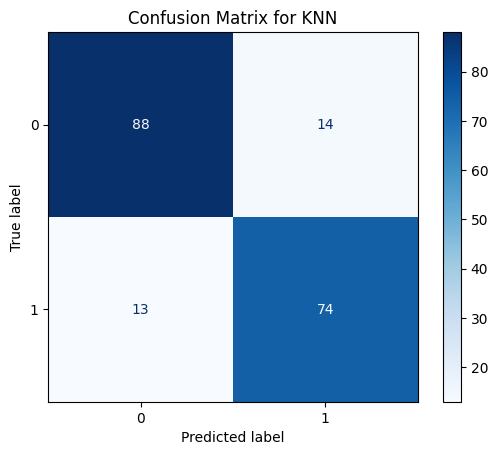

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt  # Ensure plt is imported

if 'KNN' in best_models:
    print("\nConfusion Matrix for KNN:")
    y_pred_knn = best_models['KNN'].predict(X_test)
    cm = confusion_matrix(y_test, y_pred_knn)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for KNN")
    plt.show()
